## Forecasting Gas Prices With Machine Learning Methods

In this Notebook, I extract data on gas prices from a CSV file and try to forecast the data from up to one year past the latest date given in the dataset.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import Ridge, LinearRegression
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
csv_path = Path.home() /"downloads"/ "Nat_Gas.csv"
df = pd.read_csv(csv_path,low_memory = False)

In [16]:
df['Dates'] = pd.to_datetime(df['Dates'])
df['Months_since_start'] = (df['Dates'] - df['Dates'].min()) / np.timedelta64(4, 'W')
def linear_sin_model(x, a, b, c, d, e, f):
    """
    Linear and trig function mixed
    x = Input date array (in months since start of data)
    a,b,c: Coeffs for linear component
    d,e,f: coeffs for trig component
    """
    return a * x + b + d + np.sin(2*np.pi*(e*x+f)) + c

x_data = df['Months_since_start']
y_data = df['Prices']
params, params_covariance = curve_fit(linear_sin_model, x_data, y_data, p0=[0.01,10,0,1,0.1,0])

params

x_model = np.linspace(x_data.min(),x_data.max(), 300)
y_model = linear_sin_model(x_model, *params)

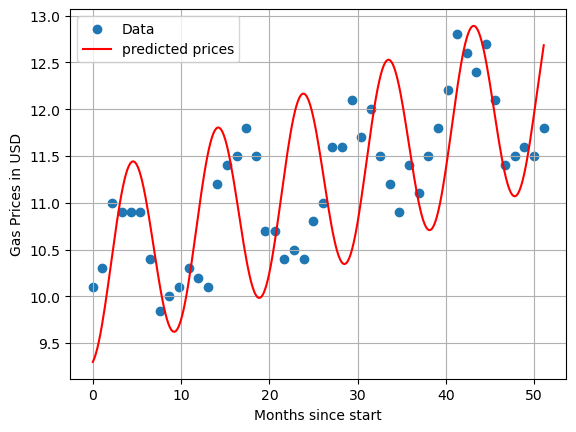

In [19]:
plt.scatter(x_data,y_data,label = 'Data')
plt.plot(x_model,y_model,color = 'red',label = 'predicted prices')
plt.xlabel('Months since start')
plt.ylabel('Gas Prices in USD')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def predict_gas_price(date):
    input_date = pd.to_datetime(date)
    if input_date in df['Dates'].values:
        return df.loc[df['Dates'] == input_date, 'Prices'].values[0]
    else:
        months_since_start = (input_date - df['Dates'].min()) / np.timedelta64(4,'W')
        predicted_price = linear_sin_model(months_since_start, *params)
        return predicted_price

test_historical = "12/31/22"
test_future = "4/30/25"

predict_gas_price(test_historical), predict_gas_price(test_future)

(11.6, 11.73353627929464)

In [ ]:
def calculate_contract_value(injection_dates, withdrawal_dates,
                             injection_rate, injection_withdrawal_costs,
                             max_storage_volume, storage_cost_per_month):
    total_profit = 0
    avg_months = 30.42

    for i in range(len(injection_dates)):
        injection_price = predict_gas_price(injection_dates[i])
        print("injection price:", injection_price)
        withdrawal_price = predict_gas_price(withdrawal_dates[i])
        print("withdrawal price:", withdrawal_price)

        months_in_store = round(pd.to_datetime(withdrawal_dates[i]) - pd.to_datetime(injection_dates[i])).days
        print("months in store:", months_in_store)
        total_injected_volume = min(months_in_store * injection_rate, max_storage_volume)
        print("Total injected volume:", total_injected_volume)

        cost_of_injection = (total_injected_volume * injection_price) - (total_injected_volume/1000000 * injection_withdrawal_costs)
        revenue_from_sale = total_injected_volume * injection_price

        print("Revenue from sale:", revenue_from_sale)
        total_storage_cost = months_in_s